In [1]:
import sys

sys.path.append("../")
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from datasets.simulated.data_generators import (
    LookupTableDataGenerator,
    SyntacticDataGenerator,
)


def topological_similarity(w, z):
    w = F.one_hot(torch.from_numpy(w)).float().numpy().reshape(w.shape[0], -1)
    z_rdm = pdist(z, metric="euclidean")
    w_rdm = pdist(w, metric="cityblock")
    topsim = pearsonr(z_rdm, w_rdm).statistic
    return topsim

# Lookup table

### Varying the sentence length

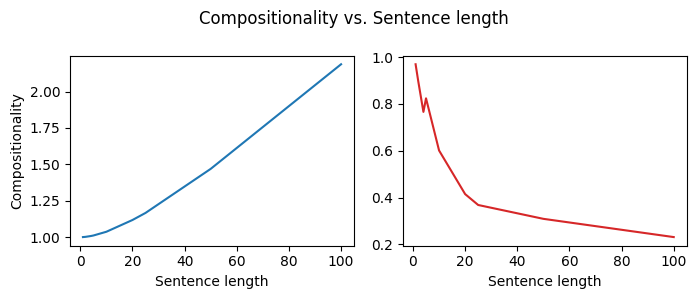

In [18]:
d = 100
compositionalities = []
ks = []
topsims = []
for k in range(1, d + 1):
    if d % k != 0:  # skip non-divisible k
        continue
    data_gen = LookupTableDataGenerator(
        num_words=k, vocab_size=10, z_dim=d, disentanglement=1, noise_ratio=0.01
    )
    w, z = data_gen.sample(1000)
    compositionalities.append(data_gen.compositionality(z, w, per_sample=True))
    ks.append(k)
    topsims.append(topological_similarity(w, z))

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
sns.lineplot(x=ks, y=compositionalities, color=sns.color_palette()[0], ax=axs[0])
sns.lineplot(x=ks, y=topsims, color=sns.color_palette()[3], legend=False, ax=axs[1])
fig.suptitle("Compositionality vs. Sentence length")
axs[0].set_xlabel("Sentence length")
axs[1].set_xlabel("Sentence length")
axs[0].set_ylabel("Compositionality")
fig.tight_layout()
plt.show()

### Varying the dimensionality of the representation

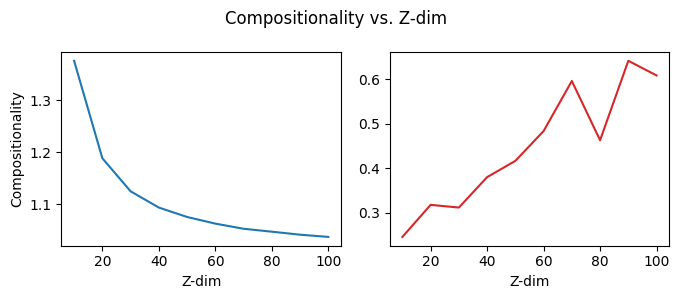

In [2]:
k = 10
compositionalities = []
ds = []
topsims = []
for d in range(k, k * 10 + 1):
    if d % k != 0:  # skip non-divisible k
        continue
    data_gen = LookupTableDataGenerator(
        num_words=k, vocab_size=10, z_dim=d, disentanglement=1, noise_ratio=0.01
    )
    w, z = data_gen.sample(1000)
    compositionalities.append(data_gen.compositionality(z, w, per_sample=True))
    ds.append(d)
    topsims.append(topological_similarity(w, z))

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
sns.lineplot(x=ds, y=compositionalities, color=sns.color_palette()[0], ax=axs[0])
sns.lineplot(x=ds, y=topsims, color=sns.color_palette()[3], legend=False, ax=axs[1])
fig.suptitle("Compositionality vs. Z-dim")
axs[0].set_xlabel("Z-dim")
axs[1].set_xlabel("Z-dim")
axs[0].set_ylabel("Compositionality")
fig.tight_layout()
plt.show()

## Varying the vocabulary size

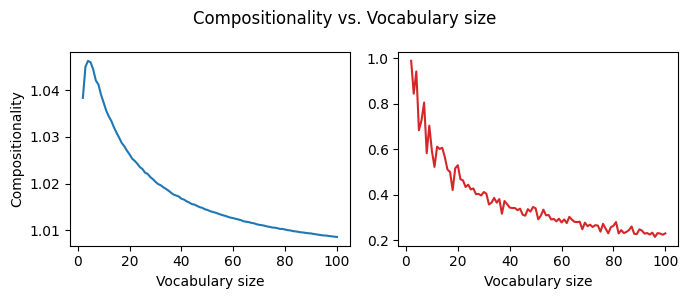

In [3]:
vmax = 100
compositionalities = []
vs = []
topsims = []
for v in range(2, vmax + 1):
    data_gen = LookupTableDataGenerator(
        num_words=10, vocab_size=v, z_dim=100, disentanglement=1, noise_ratio=0.01
    )
    w, z = data_gen.sample(1000)
    compositionalities.append(data_gen.compositionality(z, w, per_sample=True))
    vs.append(v)
    topsims.append(topological_similarity(w, z))

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
sns.lineplot(x=vs, y=compositionalities, color=sns.color_palette()[0], ax=axs[0])
sns.lineplot(x=vs, y=topsims, color=sns.color_palette()[3], legend=False, ax=axs[1])
fig.suptitle("Compositionality vs. Vocabulary size")
axs[0].set_xlabel("Vocabulary size")
axs[1].set_xlabel("Vocabulary size")
axs[0].set_ylabel("Compositionality")
fig.tight_layout()
plt.show()

### Varying the disentanglement

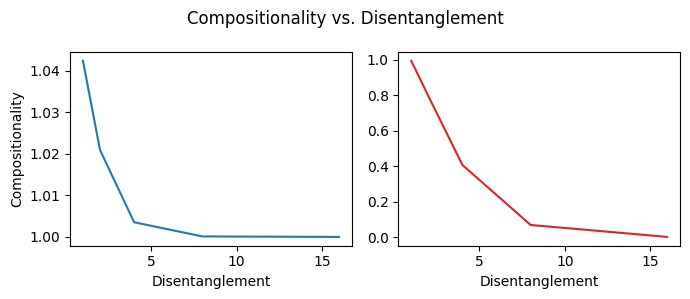

In [4]:
k = 16
z_dim = k * 10
compositionalities = []
ds = []
topsims = []
for d in range(1, k + 1):
    if k % d != 0:
        continue
    data_gen = LookupTableDataGenerator(
        num_words=k, vocab_size=2, z_dim=z_dim, disentanglement=d, noise_ratio=0.01
    )
    w, z = data_gen.sample(1000)
    compositionalities.append(data_gen.compositionality(z, w, per_sample=True))
    ds.append(d)
    topsims.append(topological_similarity(w, z))

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
sns.lineplot(x=ds, y=compositionalities, color=sns.color_palette()[0], ax=axs[0])
sns.lineplot(x=ds, y=topsims, color=sns.color_palette()[3], legend=False, ax=axs[1])
fig.suptitle("Compositionality vs. Disentanglement")
axs[0].set_xlabel("Disentanglement")
axs[1].set_xlabel("Disentanglement")
axs[0].set_ylabel("Compositionality")
fig.tight_layout()
plt.show()

# Hierarchical syntax

### Varying the number of rules

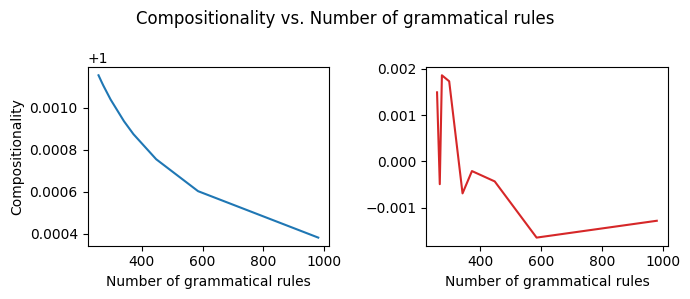

In [6]:
z_dim = 10
num_words = 64
vocab_size = 2048
num_terminal_pos = 16


def gen_grammar(num_terminal_pos, decay_rate):
    grammar = {}
    pairs = list(product(range(num_terminal_pos), repeat=2))
    next_pos = num_terminal_pos
    num_pos = max(int(decay_rate * num_terminal_pos), 1)
    while len(pairs) > 1:
        for i, pair in enumerate(pairs):
            grammar[pair] = next_pos + i % num_pos
        pairs = list(product(range(next_pos, next_pos + num_pos), repeat=2))
        next_pos += num_pos
        num_pos = max(int(decay_rate * num_pos), 1)
    grammar[(next_pos - 1, next_pos - 1)] = next_pos - 1
    return grammar


compositionalities = []
num_grammar_rules = []
topsims = []
for decay_rate in np.linspace(0.1, 0.9, 9):
    grammar = gen_grammar(num_terminal_pos, decay_rate)
    data_gen = SyntacticDataGenerator(
        z_dim=z_dim,
        num_words=num_words,
        vocab_size=vocab_size,
        num_terminal_pos=num_terminal_pos,
        grammar=grammar,
        noise_ratio=0.01,
    )
    w, z = data_gen.sample(1000)
    compositionalities.append(data_gen.compositionality(z, w, per_sample=True))
    num_grammar_rules.append(len(grammar))
    topsims.append(topological_similarity(w, z))

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
sns.lineplot(x=num_grammar_rules, y=compositionalities, color=sns.color_palette()[0], ax=axs[0])
sns.lineplot(x=num_grammar_rules, y=topsims, color=sns.color_palette()[3], legend=False, ax=axs[1])
fig.suptitle("Compositionality vs. Number of grammatical rules")
axs[0].set_xlabel("Number of grammatical rules")
axs[1].set_xlabel("Number of grammatical rules")
axs[0].set_ylabel("Compositionality")
fig.tight_layout()
plt.show()

### Natural toy grammar

Taken from [here](https://pages.uoregon.edu/tpayne/UEG/UEG-exercises-ch8.pdf) for now